<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/totalsegmentator_mwe_vamsi_040323_mhubai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Whole Body CT Segmentation with TotalSegmentator**

This notebook provides a minimal working example of TotalSegmentator, a tool for the segmentation of 104 anatomical structures from CT images. The model was trained using a wide range of imaging CT data of different pathologies from several scanners, protocols and institutions.



We test TotalSegmentator by implementing an end-to-end (cloud-based) pipeline on publicly available whole body CT scans hosted on the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/), starting from raw DICOM CT data and ending with a DICOM SEG object storing the segmentation masks generated by the AI model. The testing dataset we use is external and independent from the data used in the development phase of the model (training and validation) and is composed by a wide variety of image types (from the area covered by the scan, to the presence of contrast and various types of artefacts).


The way all the operations are executed - from pulling data, to data postprocessing, and the standardisation of the results - have the goal of promoting transparency and reproducibility. Furthermore, this notebook is part of [a collection of code, notebooks and Docker containers](https://github.com/AIM-Harvard/mhub/blob/main/mhub/totalsegmentator/notebooks/totalsegmentator_mwe.ipynb) we are developing with the goal of making a wide range of machine learning models for medicine available through a standardized I/O framework.



Papermill package is used as a tool for parameterizing and executing Jupyter notebooks. One advantage of using Papermill is that it allows you to use the same notebook in different environments, such as in a Docker container. By parameterizing the notebook using Papermill, you can easily change the values of variables or comment out cells that install packages when running the notebook in a Docker environment. This makes it easier to reuse and share notebooks across different environments.


Please cite the following article if you use this code or pre-trained models:

Wasserthal, J., Meyer, M., Breit, H.C., Cyriac, J., Yang, S. and Segeroth, M., 2022. TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. arXiv preprint arXiv:2208.05868, [
https://doi.org/10.48550/arXiv.2208.05868]( 	
https://doi.org/10.48550/arXiv.2208.05868).

The original code is published on
[GitHub](https://github.com/wasserth/TotalSegmentator)  using the [Apache-2.0 license](https://github.com/wasserth/TotalSegmentator/blob/master/LICENSE).

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Shackleford, James A., Nagarajan Kandasamy and Gregory C. Sharp. “Plastimatch—An Open-Source Software for Radiotherapy Imaging.” (2014).

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

### **Disclaimer**

The code and data of this repository are provided to promote reproducible research. They are not intended for clinical care or commercial use.

The software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose and noninfringement. In no event shall the authors or copyright holders be liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, arising from, out of or in connection with the software or the use or other dealings in the software.

# **Installing Packages**
(Comment out these lines when using for Terra/ Seven Bridges Genomics as a docker image will provide the environment)

In [1]:
%%capture
!apt-get update && apt-get install lz4 git dcm2niix subversion plastimatch

In [2]:
%%capture
#utility to make yaml files easily editable in a notebook cell
!pip install yamlmagic thedicomsort pyplastimatch TotalSegmentator nvidia-ml-py3

In [3]:
 !pip install git+https://github.com/MHubAI/mhubio.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MHubAI/mhubio.git to /tmp/pip-req-build-rmcwd56b
  Running command git clone --filter=blob:none --quiet https://github.com/MHubAI/mhubio.git /tmp/pip-req-build-rmcwd56b
  Resolved https://github.com/MHubAI/mhubio.git to commit 49076c6f2947468e29793bd129c446a41a984a67
  Preparing metadata (setup.py) ... done
  Created wheel for mhubio: filename=mhubio-0.0.1-py3-none-any.whl size=47216 sha256=b063a0d144d5005a4476a38ab0802ae9f77def1d0f752e531cbacf50098db107
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnwm1x29/wheels/c1/0b/f4/f20a7a8897889f673174e7963804734c6025053fe8a1680534
Successfully built mhubio


In [4]:
%%capture
# Download s5cmd version 2.0.0 for Linux 64-bit from GitHub
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"

# Extract the downloaded tar.gz file
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"

# Remove the downloaded tar.gz file
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"

# Move the s5cmd binary to /usr/local/bin so it can be used from anywhere on the system
!mv s5cmd /usr/local/bin/s5cmd

# Remove the dcmqi path
!rm CHANGELOG.md LICENSE README.md

In [5]:
%%capture
#Set the URL for the dcmqi release to download
dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"

#Set the path where the downloaded file will be saved
dcmqi_download_path = "dcmqi-1.2.5-linux.tar.gz"

#set the path where the extracted contents of the downloaded file will be saved
dcmqi_path = "dcmqi-1.2.5-linux"

#Download the dcmqi release from the specified URL and save it to the specified path
!wget -O $dcmqi_download_path $dcmqi_release_url

#Extract the contents of the downloaded file to the specified path
!tar -xvf $dcmqi_download_path

# Remove the downloaded tar.gz file
!rm $dcmqi_download_path

#Move the contents of the bin directory within the extracted dcmqi directory to the /bin directory on the system
!mv $dcmqi_path/bin/* /bin

# Remove the dcmqi path
!rm -r $dcmqi_path

#**Importing Packages**#

In [6]:
# Import commonly used libraries
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from time import sleep

import glob
import matplotlib.pyplot as plt
import numpy as np
import nvidia_smi
import os
import pandas as pd
import psutil
import random
import shutil
import sys
import time
import yaml

# Set the current working directory 
curr_dir   = Path().absolute()

# Set the time zone to 'US/Eastern' 
os.environ['TZ'] = 'US/Eastern'
time.tzset()

# Get the current time 
current_time = time.strftime('%a %b %d %H:%M:%S %Y', time.localtime())
print(current_time)

# Print the current directory and the version of Python being used
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Tue Apr 04 15:32:16 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [7]:
#Load yamlmagic extension that will be used to create yamlfiles
%load_ext yamlmagic

#**Parameters for Papermill**#
(useful for parameterizing and/or for Terra/Seven Bridges Genomics)

In [8]:
#Papermill will inject a cell below this cell with the values passed from the runtime
#Remember to tag this cell as 'parameters' in jupyterlab/jupyter notebook 
#https://papermill.readthedocs.io/en/latest/

compressedCSVFilePath =''
FastModeStatus= True
converterType='dcm2niix'

#**Reading CSV File containing s5cmd Urls**#
(The csv file expects SeriesInstanceUID and their corresponding S5cmd Urls) The query used for this study: https://github.com/vkt1414/Cloud-Resources-Workflows/blob/main/sqlQueries/nlstCohort.sql




In [9]:
# Decompress the compressed csv file in .lz4 format in the current working directory
#!lz4 -d $compressedCSVFilePath
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
# Use glob to find all files with a .csv extension in the current working directory
csv_file_path = glob.glob('*.csv')[0]

# Alternatively, you can manually specify the path to the csv file
# csv_file_path= '/home/vamsi/Downloads/result.csv'
# Record the current time
start_time = time.time()

# Read the csv file specified by the csv_file_path variable using the pandas library
cohort_df = pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')

# Calculate the time it took to read the csv file
read_time = time.time() - start_time

print('read in ' + str(read_time) + ' seconds')

--2023-04-04 15:32:16--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-04-04 15:32:16 (6.02 MB/s) - ‘batch_1.csv’ saved [139861/139861]

read in 0.01259756088256836 seconds


In [10]:
SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
SeriesInstanceUIDs

['1.3.6.1.4.1.14519.5.2.1.7009.9004.118722452529394350711166589345',
 '1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033',
 '1.2.840.113654.2.55.100875189782210690344207306235124901243',
 '1.2.840.113654.2.55.113040386178547843571271236478024341696',
 '1.2.840.113654.2.55.142419057730651121165090739113900499978',
 '1.2.840.113654.2.55.14382674871619950799472325766084940706',
 '1.2.840.113654.2.55.146601594654322994982630019583270053397',
 '1.2.840.113654.2.55.154809705591242159075253605419469935510',
 '1.2.840.113654.2.55.185309182591805634517860395342326800332',
 '1.2.840.113654.2.55.216614002338888733987350522981366678482',
 '1.2.840.113654.2.55.22770087029972268579113866309746562015',
 '1.2.840.113654.2.55.243990451406006403331425809632881193215']

#**Importing Source Code From MHubAI repo**#
MHubAI utilities and curated TotalSegmentator model are used for converting DICOM Series to a NIfTI and then applying the TotalSegmentator model. Finally the NIfTI file from Inference is converted back to DICOM SEG object 
```
DICOM CT >> NIfTI >> TotalSegmentator >> NIfTI >> DICOM SEG 
```

In [11]:
%%capture
# Try to remove the directories 'models' and 'mhubio' if they exist
try:
    shutil.rmtree('models')
    shutil.rmtree('mhubio')
except OSError:
    pass

# Clone the repository from GitHub using a sparse checkout to only download specific files or directories
!git clone --filter=blob:none --no-checkout https://github.com/vkt1414/models.git models

# Change the current working directory to the newly cloned repository
%cd models

# Checkout a specific commit
!git checkout 33fb1dd


# Initialize the sparse-checkout
!git sparse-checkout init

# Set the sparse-checkout to only include the 'models/totalsegmentator' directory
!git sparse-checkout set models/totalsegmentator

# Change the current working directory back to the previous one
%cd ..

## **Setup mhubio**##

`mhbio` is the module of MHubAI that deals with all of the basic operations shared between a large majority of the models.


In [12]:
sys.path.append('.')

from mhubio.core import Config, DataType, FileType, CT, SEG

from mhubio.modules.importer.UnsortedDicomImporter import UnsortedInstanceImporter
from mhubio.modules.importer.DataSorter import DataSorter
from mhubio.modules.convert.NiftiConverter import NiftiConverter
from mhubio.modules.convert.DsegConverter import DsegConverter
from mhubio.modules.organizer.DataOrganizer import DataOrganizer
from models.models.totalsegmentator.utils.TotalSegmentatorRunner import TotalSegmentatorRunner

The config file stores all the information needed by the different modules, such as the path to a given file or folder, to execute the end-to-end pipeline.

For instance, we specify `data_base_dir` as a `general` argument all the modules are going to share. Then, we specify the module-specific arguments.

For instance, we specify the directory where the DICOM data to be sorted are for the `UnsortedInstanceImporter`, by adding `input_dir` to the config file. We can also specify the structure of the sorted directory by setting the `structure` argument for the `DataSorter`, or which `TotalSegmentator` model to run.

Write a custom configuration file containing the specifics for all the MHub modules we're going to use, using the `%%writefile` magik (from the `yamlmagic` package).

This file is going to be tailored to this specific use case and example.

In [13]:
%%writefile totalsegmentator_config.yml
general:
  data_base_dir: /content/data
modules:
  NiftiConverter:
    engine: plastimatch
  UnsortedInstanceImporter:
    input_dir: /content/idc_data
  DataSorter:
    bypass: True
    base_dir: /content/data/sorted
    structure: '%SeriesInstanceUID/dicom/%SOPInstanceUID.dcm'
  DsegConverter:
    dicomseg_json_path: /content/models/models/totalsegmentator/config/dicomseg_metadata_whole.json
    skip_empty_slices: True
  TotalSegmentatorRunner:
    use_fast_mode: True
    use_multi_label_output: True

Writing totalsegmentator_config.yml


In [14]:
#Edit the yaml with parameters

with open('totalsegmentator_config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Update the value of use_fast_mode with the value of FastModeStatus
config['general']['data_base_dir'] = os.path.join(curr_dir,'data')
config['modules']['NiftiConverter']['engine'] = converterType
config['modules']['DataSorter']['base_dir'] = os.path.join(curr_dir,'data/sorted')
config['modules']['UnsortedInstanceImporter']['input_dir'] = os.path.join(curr_dir,'idc_data')
config['modules']['TotalSegmentatorRunner']['use_fast_mode'] = FastModeStatus

# Write the updated dictionary back to the YAML file
with open('totalsegmentator_config.yml', 'w') as file:
    yaml.safe_dump(config, file)

# **Running the Analysis**

For instance, the workflow for this example looks like the following:


We want to start from DICOM CT data and save the results in DICOM SEG format. We are therefore going to need the relevant `DataType`(s) and `FileType`(s) imported (`CT` and the `SEG`) from our `Config` module. 

We will also need to import all the converters to run the aforementioned operations (`UnsortedInstanceImporter`, `DataSorter`, `NiftiConverter`, `DsegConverter`, `DataOrganizer`) and the model runner (`TotalSegmentatorRunner`).

For more in-depth explanation of the modules, see the following sections.


After defining a config file for our use case, we can initialize a `Config` object using such `yml` file.

The `Config` object is passed along to all the modules, and keeps track of all of the information that need to shared among these modules.

In [15]:
# config
config = Config('totalsegmentator_config.yml')
config.verbose = True  
type(config)

mhubio.core.Config.Config

In the next cells, we define a utility function to pull data from the Imaging Data Commons - starting from the DataFrame `patient_df` we have previously defined - and then cross-load the data from the IDC Buckets to this Colab instance.

In [16]:
def download_patient_data(series_id):

  """
  Download raw DICOM data and run dicomsort to standardise the input format.
  Arguments:
    series_id : required - SeriesInstanceUID

  Make sure to check the s5cmd urls for the destination directory 
  In this study, the s5cmd urls have idc_data as the destination 

  """
  global cohort_df
  s5cmd_file_path = "s5cmd_manifest.txt"
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(s5cmd_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [24]:
def check_dicom_conversion_errors(series_id):
    if len(glob.glob('data/sorted/*.nii.gz')) > 1:
        with open('error_file.txt', 'a') as f:
            f.write(f"Error: More than one file in {series_id}\n")
        return True
    else:
        return False

In [72]:
def download_and_process_series(series_id):
    try:
      shutil.rmtree('data')
      shutil.rmtree('idc_data')
      os.remove('s5cmd_manifest')
    except OSError:
      pass
    os.system("mkdir -p data/")
    os.system("mkdir -p data/sorted")
    os.system("mkdir -p dicom_segs")

    start_time = time.time()
    download_patient_data(series_id)
    download_time = time.time() - start_time

    start_time = time.time()
    importer = UnsortedInstanceImporter(config)
    importer.execute()
    importer_time = time.time() - start_time

    start_time = time.time()
    DataSorter(config).execute()
    DataSorter_time=time.time()- start_time

    start_time = time.time()
    NiftiConverter(config).execute()
    NiftiConverter_time = time.time() - start_time

    start_time = time.time()
    TotalSegmentatorRunner(config).execute()
    TotalSegmentatorRunner_time = time.time() - start_time
    
    
    start_time = time.time()
    try:
      DsegConverter(config).execute()
    except:
      check_dicom_conversion_errors(series_id)
    DsegConverter_time = time.time() - start_time
    
    start_time = time.time()
    try:
      archive_fn = "{}.dcm.lz4".format(series_id)
    except OSError:
      pass
    archiving_time = time.time() - start_time

    try:
      os.remove(archive_fn)
    except OSError:
      pass
    !lz4 data/sorted/seg.dcm {archive_fn}
    !mv {archive_fn} dicom_segs/
    

    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})
    log['download_time'] = download_time
    log['importer_time'] = importer_time
    log['NiftiConverter_time'] = NiftiConverter_time
    log['TotalSegmentatorRunner_time'] = TotalSegmentatorRunner_time
    log['DsegConverter_time'] = DsegConverter_time
    log['archiving_time'] = archiving_time
    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)





In [73]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total
 

Copying files from IDC buckets
Done in 0.938929 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.00013423 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.26354 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 8.18656 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 19.8496 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.dc

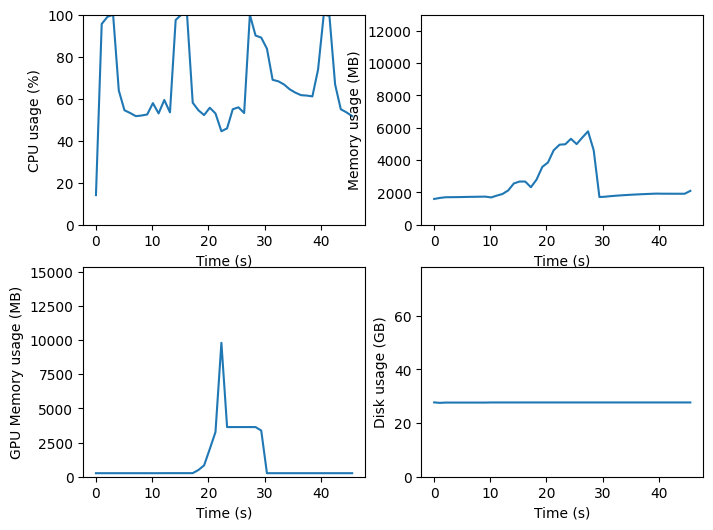

Copying files from IDC buckets
Done in 0.721368 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000333309 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.115264 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
CONVERT ERROR: File not created:  /content/data/sorted/image.nii.gz
Done in 5.28893 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Error while running model for instance <I:/content/data/sorted>: [Errno 2] No such file or directory: '/content/data/sorted/ts-model-out'
Done in 4.10855 seconds.

--------------------------
S

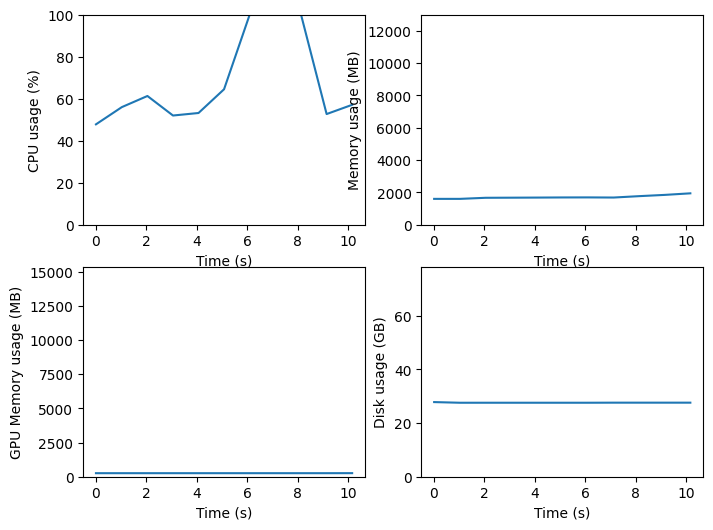

Copying files from IDC buckets
Done in 0.621492 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000145197 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.112033 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 4.98517 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 19.156 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.d

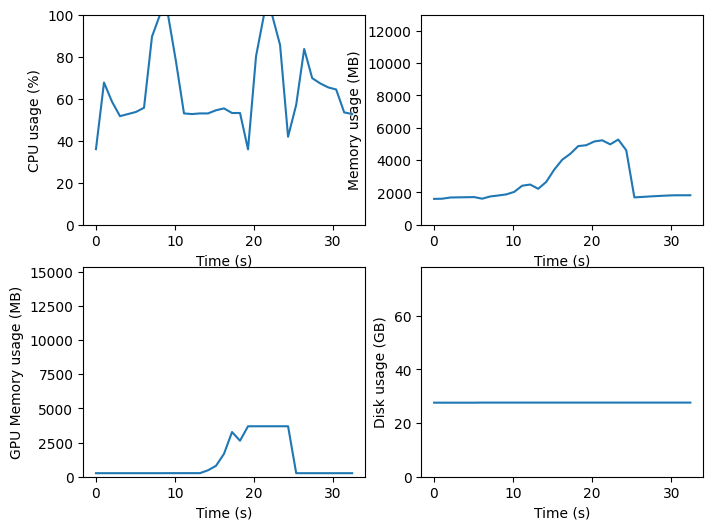

Copying files from IDC buckets
Done in 0.932374 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000149012 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.269362 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 7.35059 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 20.4898 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.

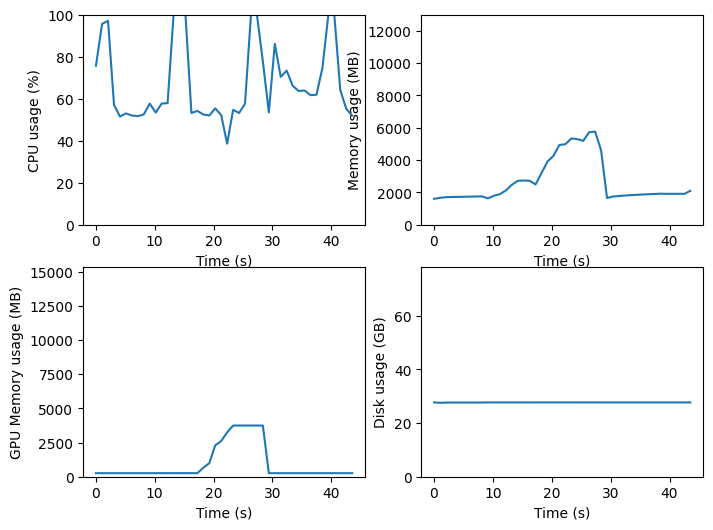

Copying files from IDC buckets
Done in 0.618389 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000172377 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.123593 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 4.27873 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 19.0824 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.

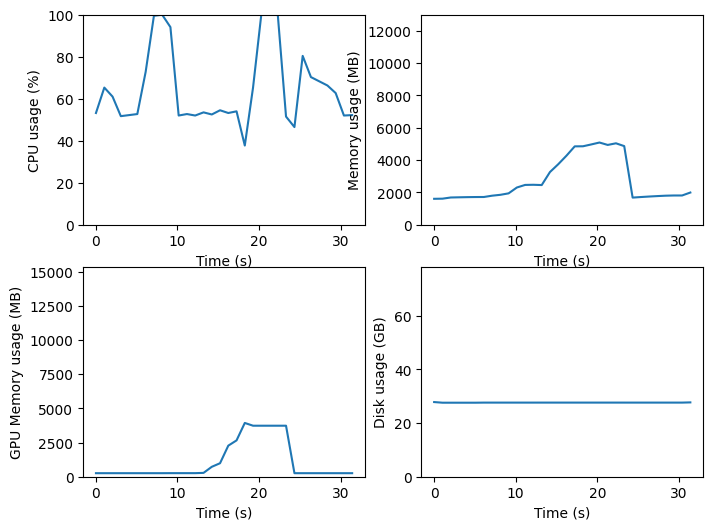

Copying files from IDC buckets
Done in 0.825749 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000595808 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.158279 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 4.49293 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 17.2582 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.

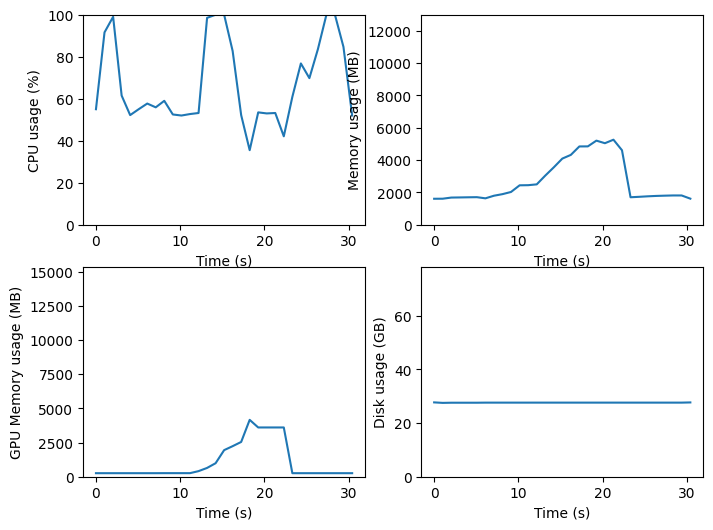

Copying files from IDC buckets
Done in 0.519895 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000136137 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.113226 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 5.29936 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 18.9457 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.

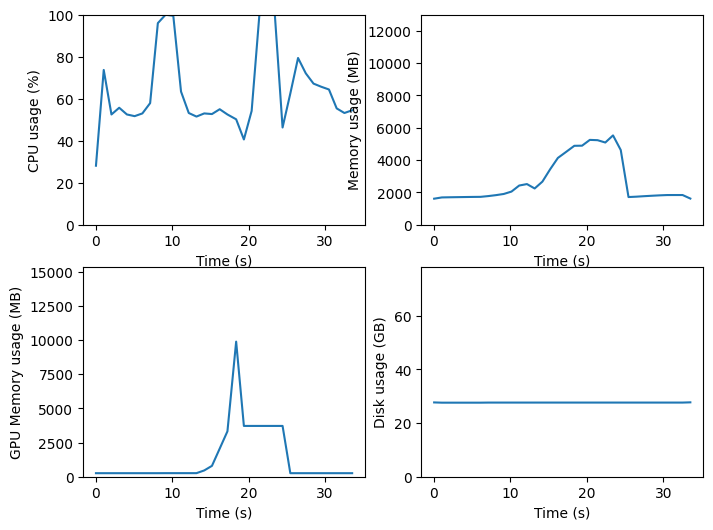

Copying files from IDC buckets
Done in 0.620923 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.00016427 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.159881 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 4.05748 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 15.6137 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.d

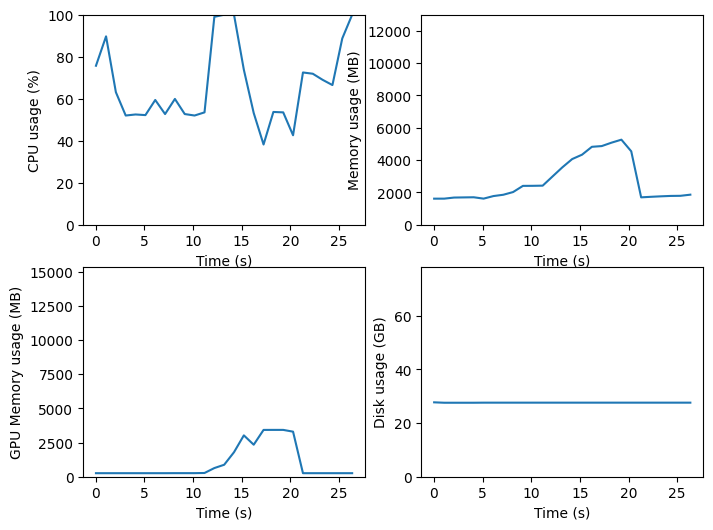

Copying files from IDC buckets
Done in 0.64928 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000136852 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.14716 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 5.54997 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 18.9963 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg.dc

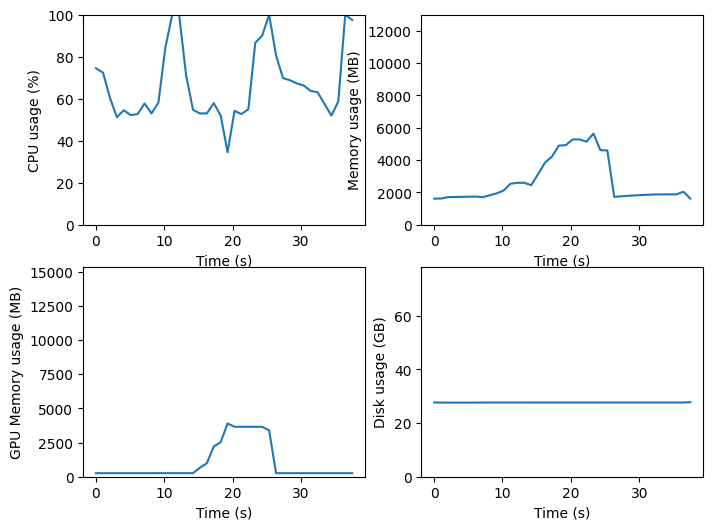

Copying files from IDC buckets
Done in 0.618341 seconds.

--------------------------
Start UnsortedInstanceImporter
Done in 0.000137329 seconds.

--------------------------
Start DataSorter
adding ct in dicom format with resolved path:  /content/data/sorted/dicom
Done in 0.0962501 seconds.

--------------------------
Start NiftiConverter
>> run:  dcm2niix -o /content/data/sorted -f image -v 1 -z y -b n /content/data/sorted/dicom
Done in 4.46137 seconds.

--------------------------
Start TotalSegmentatorRunner
Generating multi-label output ('--ml')
Running TotalSegmentator in fast mode ('--fast', 3mm)
>> run:  TotalSegmentator -i /content/data/sorted/image.nii.gz -o /content/data/sorted/ts-model-out/segmentations.nii.gz --ml --fast
Done in 17.7029 seconds.

--------------------------
Start DsegConverter
>> run:  itkimage2segimage --inputImageList /content/data/sorted/ts-model-out/segmentations.nii.gz --inputDICOMDirectory /content/data/sorted/dicom --outputDICOM /content/data/sorted/seg

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

##**Compressing Output Files**##

In [ ]:
# start_time = time.time()
# try:
#   os.remove('itkimage2segimageDICOMsegFiles.tar.lz4')
#   os.remove('metadata.tar.lz4')
# except OSError:
#   pass
# !tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
# !tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
# output_file_archiving_time = time.time() - start_time


start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/dicom_segs | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
output_archiving_time = time.time() - start_time




# **Utilization Metrics**


In [ ]:

runtime_stats.to_csv('runtime.csv')
runtime_stats['output_file_archiving_time']=output_file_archiving_time
try:
  os.remove('UsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv UsageMetrics.lz4
runtime_stats